In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import linear_model, tree, ensemble
from sklearn.preprocessing import StandardScaler, OneHotEncoder,TargetEncoder, LabelEncoder, OrdinalEncoder 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

In [114]:
import cv2 as cv

In [10]:
df=pd.read_csv('train.csv')
df.head()

,ID,age,sex,myocardial_infarctions_anamnesis,Exertional_angina_pectoris_anamnesis,FC_of_angina_pectoris,Coronary_heart_disease(CHD),Heredity_on_CHD,essential_hypertension,Symptomatic_hypertension,...,supr_tach,ven_tach,ven_fib,th_d_av,pul_ede,myo_rup,dres_syn,ch_hf,re_myin,p_inf_ang
0,6543,69.000000,female,two,3y ago,II FC,unstable,NaN,Stage 2,FALSE,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
1,6544,58.000000,male,zero,never,none,none,NaN,none,FALSE,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO
2,6545,72.000000,female,zero,>5y ago,II FC,exertional,NaN,Stage 3,?,...,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO
3,6546,73.000000,female,zero,?,IV FC,unstable,NaN,NaN,TRUE,...,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO
4,6547,75.655137,female,zero,3y ago,none,exertional,NaN,Stage 3,FALSE,...,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO


ValueError: could not convert string to float: 'two'

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Columns: 123 entries, ID to p_inf_ang
dtypes: bool(1), float64(11), int64(1), object(110)
memory usage: 1.1+ MB


In [14]:
df.isna().sum()


ID                                        0
age                                     250
sex                                     246
myocardial_infarctions_anamnesis          7
Exertional_angina_pectoris_anamnesis    160
                                       ... 
myo_rup                                   0
dres_syn                                  0
ch_hf                                     0
re_myin                                   0
p_inf_ang                                 0
Length: 123, dtype: int64

In [15]:
df.nunique()

ID                                      1190
age                                      246
sex                                        2
myocardial_infarctions_anamnesis           4
Exertional_angina_pectoris_anamnesis       8
                                        ... 
myo_rup                                    2
dres_syn                                   2
ch_hf                                      2
re_myin                                    2
p_inf_ang                                  2
Length: 123, dtype: int64

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,1190.0,7137.500000,343.667717,6543.000000,6840.25,7137.50,7434.750000,7732.000000
age,940.0,63.242062,11.410026,26.000000,56.00,64.00,71.000000,94.455567
Systolic_BP_ECT,464.0,139.094828,49.406189,0.000000,110.00,140.00,170.000000,260.000000
Diastolic_BP_ECT,434.0,83.058493,19.999228,0.000000,70.00,80.00,90.075954,197.953064
ser_K_cont,802.0,4.368080,1.056283,2.300000,3.70,4.20,4.900000,8.200000
ser_Na_cont,507.0,136.773176,8.775743,117.000000,132.00,136.00,141.500000,169.000000
ser_AIAT_cont,1041.0,0.574256,0.516971,0.030000,0.23,0.38,0.750000,3.000000
serum_AsAT_cont,829.0,0.357021,0.322560,0.040000,0.15,0.22,0.450000,2.150000
ser_cpk_cont,190.0,2.061053,0.994194,1.200000,1.25,1.60,3.600000,3.600000
wbc_count,902.0,9.468958,4.313427,2.000000,6.40,8.40,11.500000,27.900000


In [104]:
# Load the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Store the IDs for the final submission
submission_ids = test_data['ID']  # Store original IDs for final submission

# Drop irrelevant columns (ID)
train_data.drop(columns=['ID'], inplace=True)
test_data.drop(columns=['ID'], inplace=True)

# Perform replacements and conversions
replacement_mapping = {'?': 0, 'TRUE': 1, 'FALSE': 0, 'YES': 1, 'NO': 0, 'NaN':0, 'none':0, 'never':0, 'True': 1, 'False': 0, 'NA':0, 'inf':1, 'yes': 1, 'no': 0,}
train_data.replace(replacement_mapping, inplace=True)
test_data.replace(replacement_mapping, inplace=True)

train_data=train_data.fillna(0)
test_data=test_data.fillna(0)

# Convert 'sex' column to binary (0, 1)
train_data['sex'] = train_data['sex'].map({'female': 0, 'male': 1})
test_data['sex'] = test_data['sex'].map({'female': 0, 'male': 1})

# Define mapping for myocardial_infarctions_anamnesis
infarction_mapping = {'zero': 0, 'one': 1, 'two': 2, 'three': 3}

# Convert 'myocardial_infarctions_anamnesis' column to numerical values
train_data['myocardial_infarctions_anamnesis'] = train_data['myocardial_infarctions_anamnesis'].map(infarction_mapping)
test_data['myocardial_infarctions_anamnesis'] = test_data['myocardial_infarctions_anamnesis'].map(infarction_mapping)

# Convert string numbers in 'essential_hypertension' to integers, remove 'Stage' from values, replace None and NaN with 0
train_data['essential_hypertension'] = train_data['essential_hypertension'].replace({'none': 0, 'Stage ': ''}, regex=True).fillna(0)
test_data['essential_hypertension'] = test_data['essential_hypertension'].replace({'none': 0, 'Stage ': ''}, regex=True).fillna(0)

# Convert string numbers in 'chronic_Heart_failure(HF)' to integers, remove 'Stage' from values, replace None and NaN with 0
train_data['chronic_Heart_failure(HF)'] = train_data['chronic_Heart_failure(HF)'].replace({'none': 0, ' stage': ''}, regex=True).fillna(0)
test_data['chronic_Heart_failure(HF)'] = test_data['chronic_Heart_failure(HF)'].replace({'none': 0, ' stage': ''}, regex=True).fillna(0)

train_data['FC_of_angina_pectoris'] = train_data['FC_of_angina_pectoris'].replace({'none': 0, ' FC': ''}, regex=True).fillna(0)
test_data['FC_of_angina_pectoris'] = test_data['FC_of_angina_pectoris'].replace({'none': 0, ' FC': ''}, regex=True).fillna(0)

infarction_mapping2 = {'I':1,'II': 2, 'III': 3, 'IV': 4,'IIB':3}
train_data['FC_of_angina_pectoris'] = train_data['FC_of_angina_pectoris'].map(infarction_mapping2).fillna(0)
test_data['FC_of_angina_pectoris'] = test_data['FC_of_angina_pectoris'].map(infarction_mapping2).fillna(0)

train_data['chronic_Heart_failure(HF)'] = train_data['chronic_Heart_failure(HF)'].map(infarction_mapping2)
test_data['chronic_Heart_failure(HF)'] = test_data['chronic_Heart_failure(HF)'].map(infarction_mapping2)

# Define features and target variables
X_train = train_data.drop(columns=['atr_fib', 'supr_tach', 'ven_tach', 'ven_fib', 'th_d_av', 'pul_ede', 'myo_rup', 'dres_syn', 'ch_hf', 're_myin', 'p_inf_ang','anterior_myocardial_infarction', 'lateral_myocardial_infarction', 'inferior_myocardial_infarction', 'posterior_myocardial_infarction'])
y_train = train_data[['atr_fib', 'supr_tach', 'ven_tach', 'ven_fib', 'th_d_av', 'pul_ede', 'myo_rup', 'dres_syn', 'ch_hf', 're_myin', 'p_inf_ang']]
test_data.drop(columns=['anterior_myocardial_infarction', 'lateral_myocardial_infarction', 'inferior_myocardial_infarction', 'posterior_myocardial_infarction'], inplace=True)

# Extract integer values from 'Exertional_angina_pectoris_anamnesis'
X_train['Exertional_angina_pectoris_anamnesis'] = X_train['Exertional_angina_pectoris_anamnesis'].str.extract(r'(\d+)')
X_train['Exertional_angina_pectoris_anamnesis'] = X_train['Exertional_angina_pectoris_anamnesis'].astype(float).fillna(0).astype(int)

# Do the same for test data if needed
test_data['Exertional_angina_pectoris_anamnesis'] = test_data['Exertional_angina_pectoris_anamnesis'].str.extract(r'(\d+)')
test_data['Exertional_angina_pectoris_anamnesis'] = test_data['Exertional_angina_pectoris_anamnesis'].astype(float).fillna(0).astype(int)

# Convert 'no_arterial_hypertension_duration' column to numerical values
X_train['no_arterial_hypertension_duration'] = X_train['no_arterial_hypertension_duration'].str.extract(r'(\d+)')
X_train['no_arterial_hypertension_duration'] = pd.to_numeric(X_train['no_arterial_hypertension_duration'], errors='coerce').fillna(0).astype(int)

test_data['no_arterial_hypertension_duration'] = test_data['no_arterial_hypertension_duration'].str.extract(r'(\d+)')
test_data['no_arterial_hypertension_duration'] = pd.to_numeric(test_data['no_arterial_hypertension_duration'], errors='coerce').fillna(0).astype(int)

# Extract integer value from time_beg_chd column
X_train['time_beg_chd'] = X_train['time_beg_chd'].str.extract('(\d+)', expand=False).astype(float).fillna(0).astype(int)
test_data['time_beg_chd'] = test_data['time_beg_chd'].str.extract('(\d+)', expand=False).astype(float).fillna(0).astype(int)

# Mapping for relapse columns
relapse_mapping = {'There is no relapse': 0, 'Only one': 1, '2 times': 2, '3 or more times': 3}

# Apply mapping to the specified columns
X_train['Relap_1hour'] = X_train['Relap_1hour'].map(relapse_mapping).fillna(0)
X_train['relap_2day'] = X_train['relap_2day'].map(relapse_mapping).fillna(0)
X_train['relap_3day'] = X_train['relap_3day'].map(relapse_mapping).fillna(0)

test_data['Relap_1hour'] = test_data['Relap_1hour'].map(relapse_mapping).fillna(0)
test_data['relap_2day'] = test_data['relap_2day'].map(relapse_mapping).fillna(0)
test_data['relap_3day'] = test_data['relap_3day'].map(relapse_mapping).fillna(0)

chd_mapping = {'none': 0, 'unstable': 2, 'exertional': 3}

# Convert 'Coronary_heart_disease(CHD)' column to numerical values
X_train['Coronary_heart_disease(CHD)'] = X_train['Coronary_heart_disease(CHD)'].map(chd_mapping).fillna(0).astype(int)
test_data['Coronary_heart_disease(CHD)'] = test_data['Coronary_heart_disease(CHD)'].map(chd_mapping).fillna(0).astype(int)

# Mapping for nsaids_icu_1hour column
nsaids_mapping = {'once': 1, 'twice': 2, 'thrice': 3, 'four or more times': 4}

# Apply mapping to the specified column
X_train['nsaids_icu_1hour'] = X_train['nsaids_icu_1hour'].map(nsaids_mapping).fillna(0)
test_data['nsaids_icu_1hour'] = test_data['nsaids_icu_1hour'].map(nsaids_mapping).fillna(0)

# Define mapping dictionary for Heredity_on_CHD
heredity_mapping = {'not burdened': 1, 'burdened': 2}

# Convert 'Heredity_on_CHD' column to numerical values
X_train['Heredity_on_CHD'] = X_train['Heredity_on_CHD'].map(heredity_mapping).fillna(0).astype(int)
test_data['Heredity_on_CHD'] = test_data['Heredity_on_CHD'].map(heredity_mapping).fillna(0).astype(int)
# Preprocessing pipeline for numerical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Preprocessing pipeline for categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
X_train.replace(replacement_mapping, inplace=True)
X_train.fillna(0, inplace=True)
X_train = X_train.astype('float64')


<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:71: SyntaxWarning: invalid escape sequence '\d'
<>:70: SyntaxWarning: invalid escape sequence '\d'
<>:71: SyntaxWarning: invalid escape sequence '\d'
C:\Users\hrith\AppData\Local\Temp\ipykernel_30716\1020746975.py:70: SyntaxWarning: invalid escape sequence '\d'
  X_train['time_beg_chd'] = X_train['time_beg_chd'].str.extract('(\d+)', expand=False).astype(float).fillna(0).astype(int)
C:\Users\hrith\AppData\Local\Temp\ipykernel_30716\1020746975.py:71: SyntaxWarning: invalid escape sequence '\d'
  test_data['time_beg_chd'] = test_data['time_beg_chd'].str.extract('(\d+)', expand=False).astype(float).fillna(0).astype(int)


,age,sex,myocardial_infarctions_anamnesis,Exertional_angina_pectoris_anamnesis,FC_of_angina_pectoris,Coronary_heart_disease(CHD),Heredity_on_CHD,essential_hypertension,Symptomatic_hypertension,no_arterial_hypertension_duration,...,nsaids_icu_1hour,nsaids_icu_2day,nsaids_icu_3day,lido_icu,beta_block_icu,calc_block_icu,heparin_icu,acetylsal_icu,ticlid_icu,trental_icu
0,69.000000,0.0,2.0,3.0,2.0,2.0,0.0,2.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,58.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,72.000000,0.0,0.0,5.0,2.0,3.0,0.0,3.0,0.0,10.0,...,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
3,73.000000,0.0,0.0,0.0,4.0,2.0,0.0,0.0,1.0,4.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,75.655137,0.0,0.0,3.0,0.0,3.0,0.0,3.0,0.0,0.0,...,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


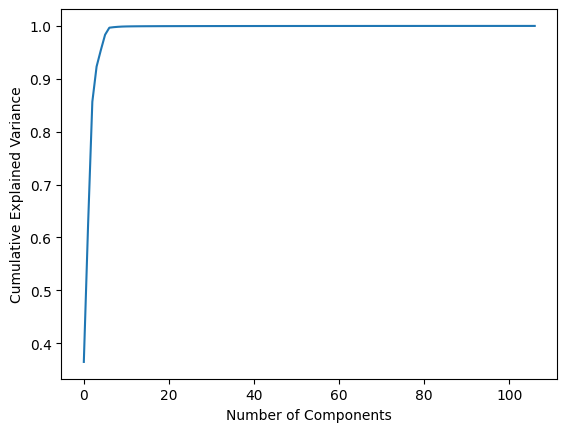

In [112]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

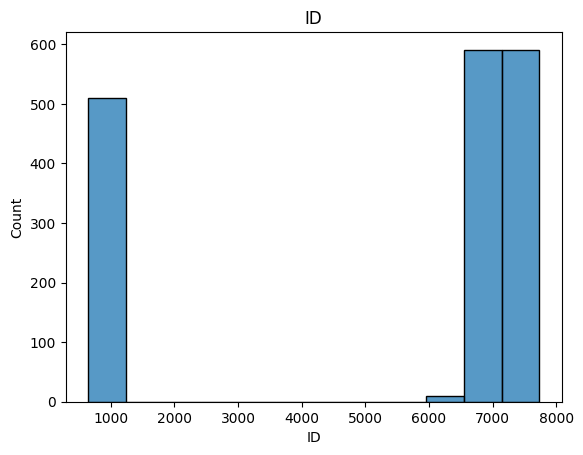

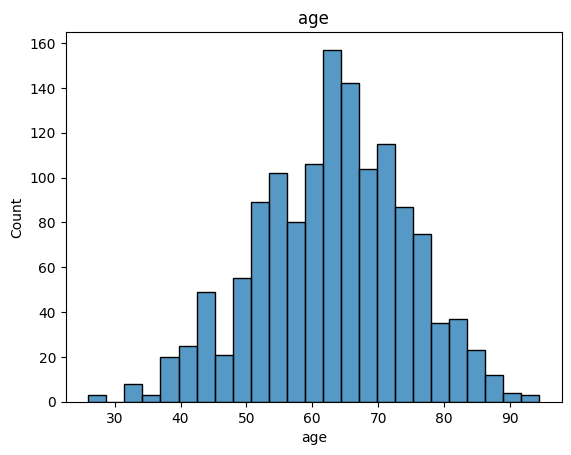

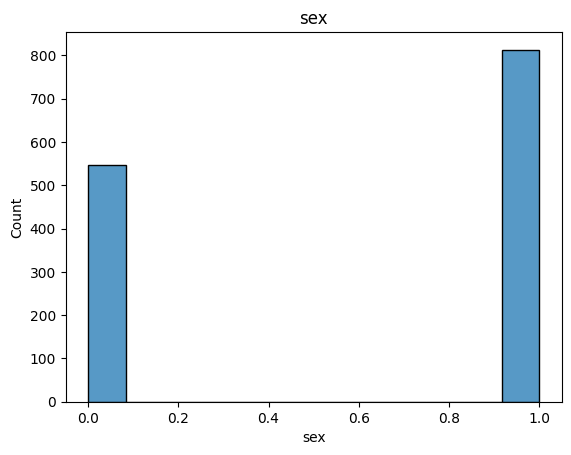

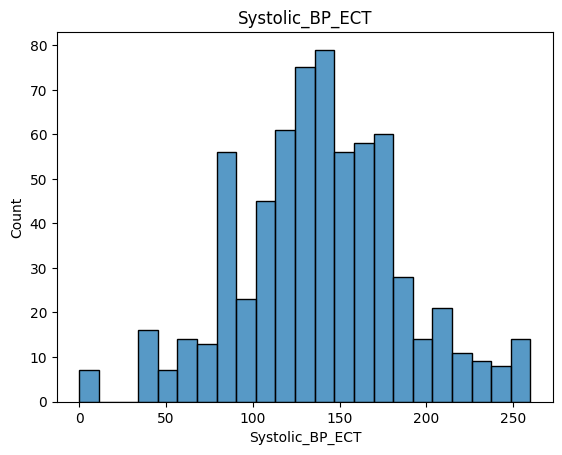

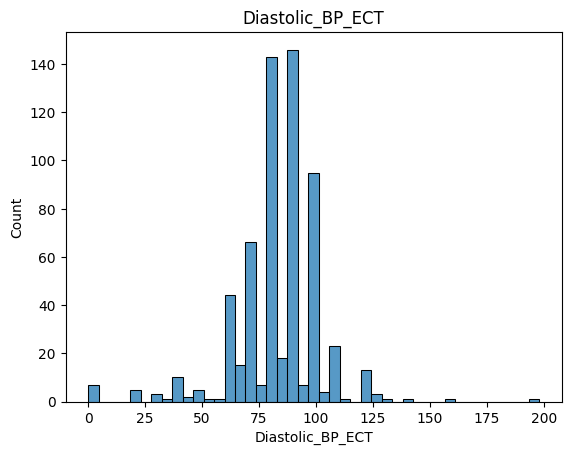

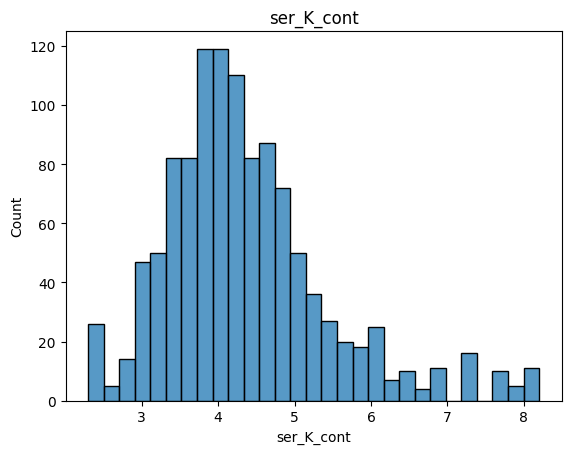

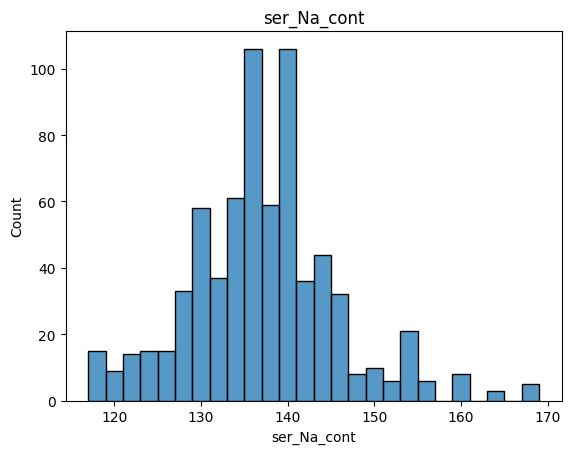

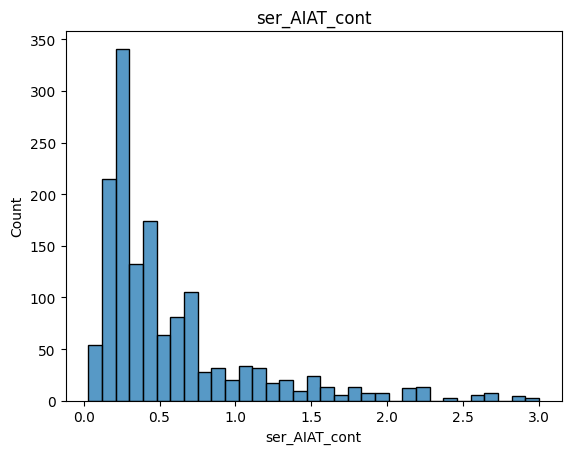

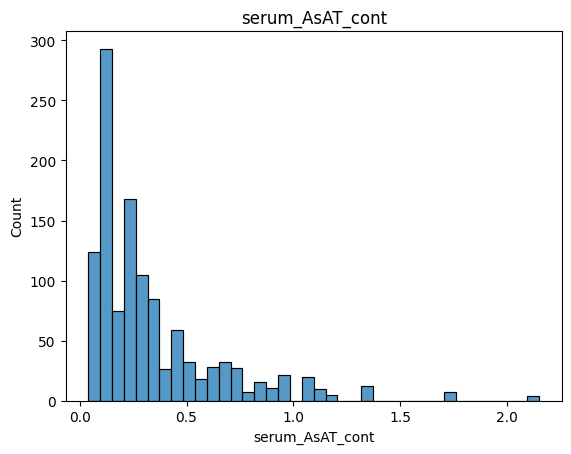

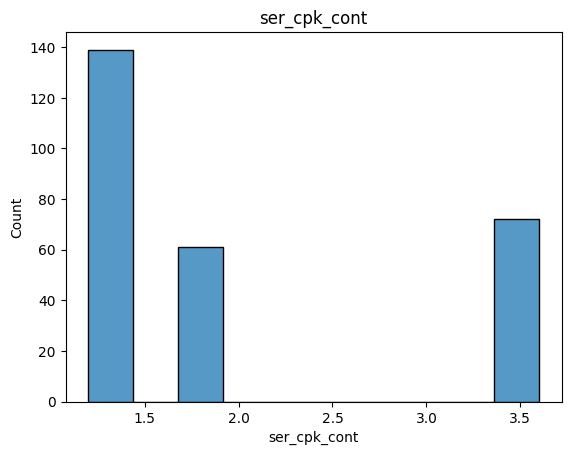

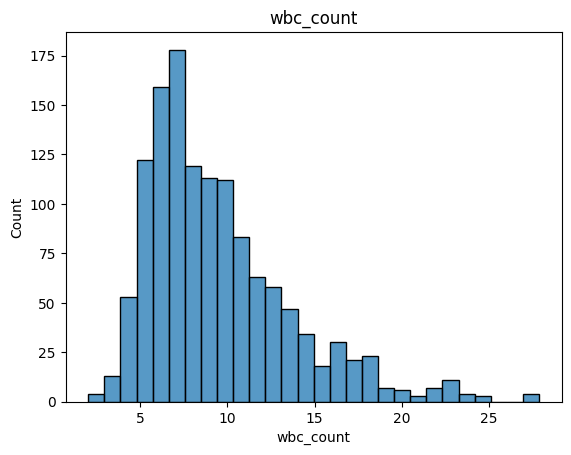

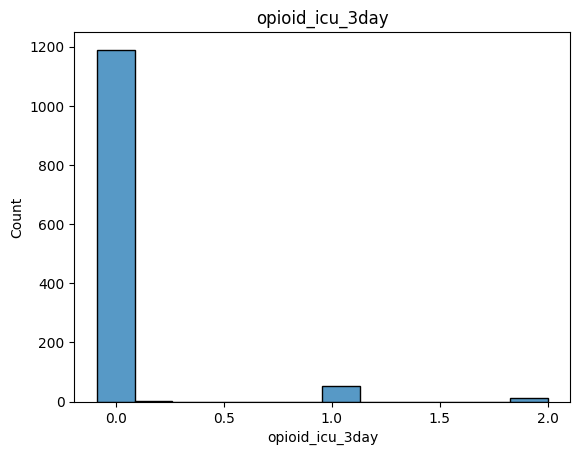

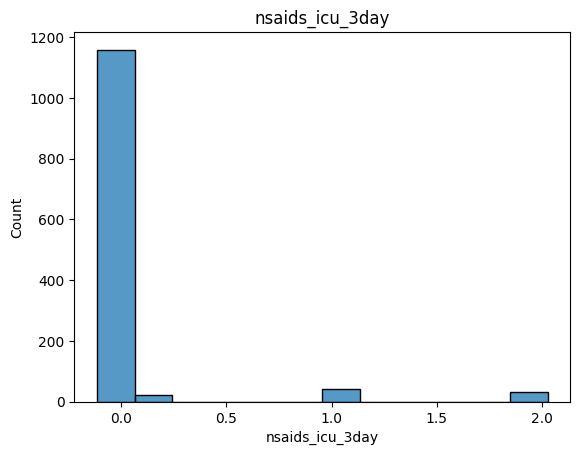

ValueError: Could not interpret value `Label` for `y`. An entry with this name does not appear in `data`.

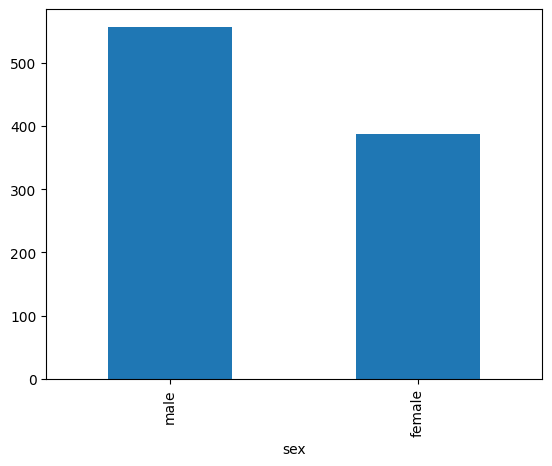

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training dataset
train_df = pd.read_csv("train.csv")

# Load the test dataset
test_df = pd.read_csv("test.csv")

# Combine the datasets for preprocessing and feature engineering
combined_df = pd.concat([train_df, test_df], ignore_index=True)

# Data Preprocessing
# Convert age to numeric type
combined_df['age'] = pd.to_numeric(combined_df['age'], errors='coerce')

# Convert categorical variables to binary
combined_df['sex'] = combined_df['sex'].map({'female': 0, 'male': 1})

# Fill missing values with appropriate methods, e.g., mean, median, mode

# Feature Engineering
# You can create new features or transform existing ones based on domain knowledge
# For example, you can create a new feature based on the duration of hypertension
combined_df['hypertension_duration'] = np.where(combined_df['Symptomatic_hypertension'] == 'TRUE',
                                                combined_df['no_arterial_hypertension_duration'],
                                                np.nan)

# Exploratory Data Analysis (EDA)
# Visualize the distribution of numerical features
numeric_cols = combined_df.select_dtypes(include=np.number).columns
for col in numeric_cols:
    sns.histplot(combined_df[col])
    plt.title(col)
    plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (assuming it's in CSV format)
data = pd.read_csv("train.csv")

# Perform data preprocessing
# Handle missing values
# Encode categorical variables

# Perform feature engineering
# Create new features
# Transform existing features

# Exploratory Data Analysis (EDA)
# Univariate analysis
data.describe()  # Summary statistics for numerical features
data['sex'].value_counts().plot(kind='bar')  # Example of plotting categorical data

# Bivariate analysis
sns.scatterplot(x='age', y='Label', data=data)  # Example of scatter plot
sns.boxplot(x='sex', y='age', data=data)  # Example of box plot

# Visualizations
sns.histplot(data['age'], bins=20, kde=True)  # Histogram
sns.pairplot(data)  # Pairplot for multiple variables

# Summary statistics
print(data.describe())  # Summary statistics for numerical features
print(data['sex'].value_counts())  # Frequency table for a categorical feature

# Show plots
plt.show()


# Visualize the correlation matrix
correlation_matrix = combined_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# Visualize the distribution of categorical features
categorical_cols = combined_df.select_dtypes(include='object').columns
for col in categorical_cols:
    sns.countplot(y=combined_df[col])
    plt.title(col)
    plt.show()

# Explore relationships between features and target variable (if available)
# For example, you can use scatter plots, box plots, or violin plots
sns.scatterplot(data=combined_df, x='age', y='Coronary_heart_disease(CHD)')
plt.title('Relationship between Age and Coronary Heart Disease')
plt.show()

# After EDA, you can proceed with feature selection, modeling, etc.


In [2]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import fbeta_score, make_scorer

# Load the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Store the IDs for the final submission
submission_ids = test_data['ID']  # Store original IDs for final submission

# Drop irrelevant columns (ID)
train_data.drop(columns=['ID'], inplace=True)
test_data.drop(columns=['ID'], inplace=True)

# Define features and target variables
X_train = train_data.drop(columns=['atr_fib', 'supr_tach', 'ven_tach', 'ven_fib', 'th_d_av', 'pul_ede', 'myo_rup', 'dres_syn', 'ch_hf', 're_myin', 'p_inf_ang'])
y_train = train_data[['atr_fib', 'supr_tach', 'ven_tach', 'ven_fib', 'th_d_av', 'pul_ede', 'myo_rup', 'dres_syn', 'ch_hf', 're_myin', 'p_inf_ang']]

# Preprocessing pipeline for numerical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing pipeline for categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Define the parameter grid
param_grid = {
    'classifier__max_depth': [50, 60, 70, None],
    'classifier__min_samples_split': [2, 4, 6],
    'classifier__min_samples_leaf': [1, 3, 5]
}

# Define models for each target variable with GridSearchCV
models = {}
for column in y_train.columns:
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier(n_estimators=150,
                                                                  criterion='entropy',
                                                                  max_features='sqrt',
                                                                  warm_start=True,
                                                                  class_weight='balanced_subsample',
                                                                  bootstrap=False,
                                                                  n_jobs=-1,max_samples=None))])
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train[column])
    models[column] = grid_search

# Display the best parameters
for column, grid_model in models.items():
    print(f"Best parameters for {column}: {grid_model.best_params_}")

# Make predictions on the test dataset using the models with the best parameters
predictions = {}
for column, grid_model in models.items():
    predictions[column] = grid_model.predict_proba(test_data)[:, 1]

# Prepare submission file
submission_df = pd.DataFrame({'ID': submission_ids})  # Use original IDs for submission
for column in y_train.columns:
    submission_df[column] = predictions[column]

# Save submission file
submission_df.to_csv('submissionwith.csv', index=False)


c:\Users\hrith\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hrith\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hrith\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\hrith\App

Best parameters for atr_fib: {'classifier__max_depth': 50, 'classifier__max_samples': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 6}
Best parameters for supr_tach: {'classifier__max_depth': 50, 'classifier__max_samples': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best parameters for ven_tach: {'classifier__max_depth': 50, 'classifier__max_samples': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best parameters for ven_fib: {'classifier__max_depth': 50, 'classifier__max_samples': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best parameters for th_d_av: {'classifier__max_depth': 50, 'classifier__max_samples': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best parameters for pul_ede: {'classifier__max_depth': 50, 'classifier__max_samples': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best parameters for

In [127]:
import sklearn
print(sklearn.__version__)

1.3.2


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Load the data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Store the IDs for the final submission
submission_ids = test_data['ID']  # Store original IDs for final submission

# Drop irrelevant columns (ID)
train_data.drop(columns=['ID'], inplace=True)
test_data.drop(columns=['ID'], inplace=True)

# Perform replacements and conversions
replacement_mapping = {'?': 0, 'TRUE': 1, 'FALSE': 0, 'YES': 1, 'NO': 0, 'NaN':0, 'none':0, 'never':0, 'True': 1, 'False': 0, 'NA':0, 'inf':1, 'yes': 1, 'no': 0,}
train_data.replace(replacement_mapping, inplace=True)
test_data.replace(replacement_mapping, inplace=True)

train_data=train_data.fillna(0)
test_data=test_data.fillna(0)

# Convert 'sex' column to binary (0, 1)
train_data['sex'] = train_data['sex'].map({'female': 0, 'male': 1})
test_data['sex'] = test_data['sex'].map({'female': 0, 'male': 1})

# Define mapping for myocardial_infarctions_anamnesis
infarction_mapping = {'zero': 0, 'one': 1, 'two': 2, 'three': 3}

# Convert 'myocardial_infarctions_anamnesis' column to numerical values
train_data['myocardial_infarctions_anamnesis'] = train_data['myocardial_infarctions_anamnesis'].map(infarction_mapping)
test_data['myocardial_infarctions_anamnesis'] = test_data['myocardial_infarctions_anamnesis'].map(infarction_mapping)

# Convert string numbers in 'essential_hypertension' to integers, remove 'Stage' from values, replace None and NaN with 0
train_data['essential_hypertension'] = train_data['essential_hypertension'].replace({'none': 0, 'Stage ': ''}, regex=True).fillna(0)
test_data['essential_hypertension'] = test_data['essential_hypertension'].replace({'none': 0, 'Stage ': ''}, regex=True).fillna(0)

# Convert string numbers in 'chronic_Heart_failure(HF)' to integers, remove 'Stage' from values, replace None and NaN with 0
train_data['chronic_Heart_failure(HF)'] = train_data['chronic_Heart_failure(HF)'].replace({'none': 0, ' stage': ''}, regex=True).fillna(0)
test_data['chronic_Heart_failure(HF)'] = test_data['chronic_Heart_failure(HF)'].replace({'none': 0, ' stage': ''}, regex=True).fillna(0)

train_data['FC_of_angina_pectoris'] = train_data['FC_of_angina_pectoris'].replace({'none': 0, ' FC': ''}, regex=True).fillna(0)
test_data['FC_of_angina_pectoris'] = test_data['FC_of_angina_pectoris'].replace({'none': 0, ' FC': ''}, regex=True).fillna(0)

infarction_mapping2 = {'I':1,'II': 2, 'III': 3, 'IV': 4,'IIB':3}
train_data['FC_of_angina_pectoris'] = train_data['FC_of_angina_pectoris'].map(infarction_mapping2).fillna(0)
test_data['FC_of_angina_pectoris'] = test_data['FC_of_angina_pectoris'].map(infarction_mapping2).fillna(0)

train_data['chronic_Heart_failure(HF)'] = train_data['chronic_Heart_failure(HF)'].map(infarction_mapping2)
test_data['chronic_Heart_failure(HF)'] = test_data['chronic_Heart_failure(HF)'].map(infarction_mapping2)

# Define features and target variables
X_train = train_data.drop(columns=['atr_fib', 'supr_tach', 'ven_tach', 'ven_fib', 'th_d_av', 'pul_ede', 'myo_rup', 'dres_syn', 'ch_hf', 're_myin', 'p_inf_ang','anterior_myocardial_infarction', 'lateral_myocardial_infarction', 'inferior_myocardial_infarction', 'posterior_myocardial_infarction'])
y_train = train_data[['atr_fib', 'supr_tach', 'ven_tach', 'ven_fib', 'th_d_av', 'pul_ede', 'myo_rup', 'dres_syn', 'ch_hf', 're_myin', 'p_inf_ang']]
test_data.drop(columns=['anterior_myocardial_infarction', 'lateral_myocardial_infarction', 'inferior_myocardial_infarction', 'posterior_myocardial_infarction'], inplace=True)

# Extract integer values from 'Exertional_angina_pectoris_anamnesis'
X_train['Exertional_angina_pectoris_anamnesis'] = X_train['Exertional_angina_pectoris_anamnesis'].str.extract(r'(\d+)')
X_train['Exertional_angina_pectoris_anamnesis'] = X_train['Exertional_angina_pectoris_anamnesis'].astype(float).fillna(0).astype(int)

# Do the same for test data if needed
test_data['Exertional_angina_pectoris_anamnesis'] = test_data['Exertional_angina_pectoris_anamnesis'].str.extract(r'(\d+)')
test_data['Exertional_angina_pectoris_anamnesis'] = test_data['Exertional_angina_pectoris_anamnesis'].astype(float).fillna(0).astype(int)

# Convert 'no_arterial_hypertension_duration' column to numerical values
X_train['no_arterial_hypertension_duration'] = X_train['no_arterial_hypertension_duration'].str.extract(r'(\d+)')
X_train['no_arterial_hypertension_duration'] = pd.to_numeric(X_train['no_arterial_hypertension_duration'], errors='coerce').fillna(0).astype(int)

test_data['no_arterial_hypertension_duration'] = test_data['no_arterial_hypertension_duration'].str.extract(r'(\d+)')
test_data['no_arterial_hypertension_duration'] = pd.to_numeric(test_data['no_arterial_hypertension_duration'], errors='coerce').fillna(0).astype(int)

# Extract integer value from time_beg_chd column
X_train['time_beg_chd'] = X_train['time_beg_chd'].str.extract('(\d+)', expand=False).astype(float).fillna(0).astype(int)
test_data['time_beg_chd'] = test_data['time_beg_chd'].str.extract('(\d+)', expand=False).astype(float).fillna(0).astype(int)

# Mapping for relapse columns
relapse_mapping = {'There is no relapse': 0, 'Only one': 1, '2 times': 2, '3 or more times': 3}

# Apply mapping to the specified columns
X_train['Relap_1hour'] = X_train['Relap_1hour'].map(relapse_mapping).fillna(0)
X_train['relap_2day'] = X_train['relap_2day'].map(relapse_mapping).fillna(0)
X_train['relap_3day'] = X_train['relap_3day'].map(relapse_mapping).fillna(0)

test_data['Relap_1hour'] = test_data['Relap_1hour'].map(relapse_mapping).fillna(0)
test_data['relap_2day'] = test_data['relap_2day'].map(relapse_mapping).fillna(0)
test_data['relap_3day'] = test_data['relap_3day'].map(relapse_mapping).fillna(0)

chd_mapping = {'none': 0, 'unstable': 2, 'exertional': 3}

# Convert 'Coronary_heart_disease(CHD)' column to numerical values
X_train['Coronary_heart_disease(CHD)'] = X_train['Coronary_heart_disease(CHD)'].map(chd_mapping).fillna(0).astype(int)
test_data['Coronary_heart_disease(CHD)'] = test_data['Coronary_heart_disease(CHD)'].map(chd_mapping).fillna(0).astype(int)

# Mapping for nsaids_icu_1hour column
nsaids_mapping = {'once': 1, 'twice': 2, 'thrice': 3, 'four or more times': 4}

# Apply mapping to the specified column
X_train['nsaids_icu_1hour'] = X_train['nsaids_icu_1hour'].map(nsaids_mapping).fillna(0)
test_data['nsaids_icu_1hour'] = test_data['nsaids_icu_1hour'].map(nsaids_mapping).fillna(0)

# Define mapping dictionary for Heredity_on_CHD
heredity_mapping = {'not burdened': 1, 'burdened': 2}

# Convert 'Heredity_on_CHD' column to numerical values
X_train['Heredity_on_CHD'] = X_train['Heredity_on_CHD'].map(heredity_mapping).fillna(0).astype(int)
test_data['Heredity_on_CHD'] = test_data['Heredity_on_CHD'].map(heredity_mapping).fillna(0).astype(int)
# Preprocessing pipeline for numerical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

# Preprocessing pipeline for categorical features
categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5,weights='distance')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
X_train.replace(replacement_mapping, inplace=True)
X_train.fillna(0, inplace=True)
X_train = X_train.astype('float64')
# Define models for each target variable
models = {}
for column in y_train.columns:
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC(probability=True))])  
    model.fit(X_train, y_train[column])
    models[column] = model

# Make predictions on the test dataset
X_test = test_data
predictions = {}
for column, model in models.items():
    predictions[column] = model.predict_proba(X_test)[:, 1]

# Prepare submission file
submission_df = pd.DataFrame({'ID': submission_ids})  # Use original IDs for submission
for column in y_train.columns:
    submission_df[column] = predictions[column]

# Save submission file
submission_df.to_csv('submissionwith.csv', index=False)